In [54]:
import numpy, random, math
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [55]:
"""
TO DO LIST:
Create a SVM classifier. Use transformation into higher dimension
in order to separate data and to create an indicator function ind(s).
Use dual formulation, kernel functions and slack variables.

DONE 1. Define a suitable kernel function (a function which takes two data points as arguments and returns a scalar value)'
   Start with the linear kernel function but explore all of the function in lab instruction section 3.3
DONE 2. Define objective (a function which takes the α-vector as argument and returns a scalar value) 
   This function should effectively implement equation 4 in the lab instructions. NOTE THAT THIS FUNCTION WILL BE CALLED
   SEVERAL HUNDRED TIMES, SO MAKE IT EFFICIENT. Define P as a global numpy array
DONE 3. Define zerofun (zerofun is a function you have defined which calculates the value which
   should be constrained to zero. Like objective, zerofun takes a vector as
   argument and returns a scalar value. 
DONE 4. Define a function that creates the matrix P from the data points  
DONE 5. Call minimize
DONE 6. Extrac the non-zero α values (use 10^-5 as the limit). Save non zero α values with the corresponding data points xi and
   target values ti in a separate data structure, for example a list.
7. Calculate b (the bias) using equation 7 in lab instruction
8. Implement the indicator function ind(s). ((equation 6) which uses the non-zero α values together with the corresponding
   xi and ti to classify new points.
9. Generate test data according to the lab instructions section 5
10. Plot the data and the decision boundary according to section 6
11. After completing above tasks with the linear kernel function, move on to questions under section 7.
""" 

"\nTO DO LIST:\nCreate a SVM classifier. Use transformation into higher dimension\nin order to separate data and to create an indicator function ind(s).\nUse dual formulation, kernel functions and slack variables.\n\nDONE 1. Define a suitable kernel function (a function which takes two data points as arguments and returns a scalar value)'\n   Start with the linear kernel function but explore all of the function in lab instruction section 3.3\nDONE 2. Define objective (a function which takes the α-vector as argument and returns a scalar value) \n   This function should effectively implement equation 4 in the lab instructions. NOTE THAT THIS FUNCTION WILL BE CALLED\n   SEVERAL HUNDRED TIMES, SO MAKE IT EFFICIENT. Define P as a global numpy array\nDONE 3. Define zerofun (zerofun is a function you have defined which calculates the value which\n   should be constrained to zero. Like objective, zerofun takes a vector as\n   argument and returns a scalar value. \nDONE 4. Define a function tha

In [68]:
def kernel(x, y):
    if (kernel_func == "linear"):
        scalar = numpy.dot(x, y)
    elif (kernel_func == "poly"):
        scalar = (numpy.dot(x, y) + 1) ** p
    elif(kernel_func == "rbf"):
        scalar = math.exp(-(numpy.linalg.norm(x-y) ** 2) / (2 * sigma ** 2))
    return scalar

def make_matrix(targets, inputs):
    # global P
    P = []
    for i in range(len(targets)):
        P.append([targets[i]*targets[j]*kernel(inputs[i], inputs[j]) for j in range(len(targets))])
    return P

## Implementing equation 4
## Should return a scalar
def objective(vector_alpha):
    scalar = 0.5 * numpy.sum(numpy.multiply(numpy.outer(vector_alpha, vector_alpha), P)) - numpy.sum(vector_alpha)
    return scalar

def zerofun(vector_alpha):
    scalar = numpy.dot(vector_alpha, targets)
    return scalar
    
def calculate_bias(low_threshold, C, alpha):
    non_zero_index = [i for i in range(len(alpha)) if alpha[i] > low_threshold]

    ## Chosse margin point aka Suport Vector
    if C != None:
        for i in range(len(non_zero_index)):
            if alpha[non_zero_index[i]] < C:
                margin_point_index = non_zero_index[i]
                break
    else:
        margin_point_index = non_zero_index[0]

    b = sum([alpha[i] * targets[i] * kernel(inputs[margin_point_index],inputs[i]) for i in range(len(alpha))]) - targets[margin_point_index]
    return b

def indicator(x, y):
    return sum([alpha[i] * targets[i] * kernel([x, y], inputs[i]) for i in range(len(alpha))]) - b

def genData():
    numpy.random.seed(100) # TODO: Comment out
    classA = numpy.concatenate((numpy.random.randn(10, 2) * 0.2 + [1.5, 0.5], numpy.random.randn(10, 2) * 0.2 + [-1.5, 0.5]))
    classB = numpy.random.randn(20, 2) * 0.2 + [0.0 , -0.5]
    inputs = numpy.concatenate((classA , classB))
    targets = numpy.concatenate((numpy.ones(classA.shape[0]), -numpy.ones(classB.shape[0])))
    N = inputs.shape[0] # Number of rows (samples)
    permute = list(range(N)) 
    random.shuffle(permute)
    inputs = inputs[permute, :]
    targets = targets[permute]
    return targets, inputs, classA, classB, N

def do_my_plot(classA, classB):
    plt.plot([p[0] for p in classA], [p[1] for p in classA], 'b.')
    plt.plot([p[0] for p in classB], [p[1] for p in classB], 'r.')
    plt.axis('equal')

    xgrid= numpy.linspace(5,5)
    ygrid = numpy.linspace(4,4)
    grid = numpy.array([[indicator(x,y) for x in xgrid] for y in ygrid])
    plt.contour(xgrid,ygrid,grid,(1.0,0.0,1.0), colors = ('red', 'black', 'blue'), linewidths=(1,3,1))



    plt.savefig('svmplot.pdf')
    plt.show()


True
Optimization terminated successfully
-1.4474411394462385


/var/folders/31/jfz2198521qchs_6wjw0cyyr0000gn/T/ipykernel_36648/2267429604.py:66: UserWarning: No contour levels were found within the data range.
  plt.contour(xgrid,ygrid,grid,(1.0,0.0,1.0), colors = ('red', 'black', 'blue'), linewidths=(1,3,1))


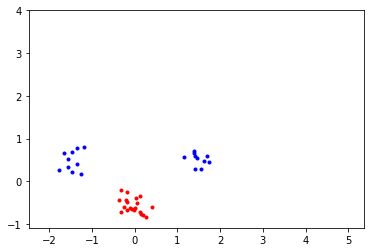

In [71]:
def main():
    global targets, inputs, N, classA, classB, b, kernel_func, p, sigma, alpha

    ## Step 1 initialize global variables
    kernel_func = 'linear'
    p = 1
    sigma = 1
    targets, inputs, classA, classB, N = genData()
    P = make_matrix(targets, inputs)

    # Easy plot TODO: Remove?
    # do_my_plot(classA, classB)
    

    # Step 2 call minimize
    C = None
    B = [(0,C) for b in range(N)] #list of pairs stating the lower and upper bounds. same length as alpha.
    XC={'type':'eq', 'fun':zerofun}
    start = numpy.zeros(N) # N = number of training samples
    ret = minimize(objective, start, bounds=B, constraints=XC) #TODO: how minimize works
    alpha = ret['x']
    print(ret['success'])
    print(ret['message'])

    #Step 3 Calculate bias
    b = calculate_bias(10**(-5), C, alpha)
    print(b)
    #Step 4 Plot
    do_my_plot(classA, classB)



    # Save non-zeros
    # non_zero_index = [i for i in range(len(alpha)) if alpha[i] > 10**(-5)]
    # non_zero_alpha = [alpha[i] for i in non_zero_index]
    # non_zero_data_points = [inputs[i] for i in non_zero_index]
    # non_zero_target_values = [targets[i] for i in non_zero_index]
    

    # print(non_zero_index)
    # print(non_zero_alpha)
    # print(non_zero_data_points)
    # print(non_zero_target_values)


main()